# Classifications et courbes ROC

La courbe ROC est une façon de visualiser la performance d'un classifieur ou plutôt sa pertinence. Voyons comment.

In [1]:
%matplotlib inline

In [2]:
from teachpyx.datasets import load_wines_dataset

data = load_wines_dataset()
X = data.drop(["quality", "color"], axis=1)
y = data["color"]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression()
clr.fit(X_train, y_train)

/home/xadupre/install/scikit-learn/sklearn/linear_model/_logistic.py:474: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [5]:
import pandas

score = clr.decision_function(X_test)
dfsc = pandas.DataFrame(score, columns=["score"])
dfsc["color"] = y_test.values
dfsc.head()

,score,color
0,8.591782,white
1,-4.745667,red
2,5.874864,white
3,6.381441,white
4,-3.017183,red


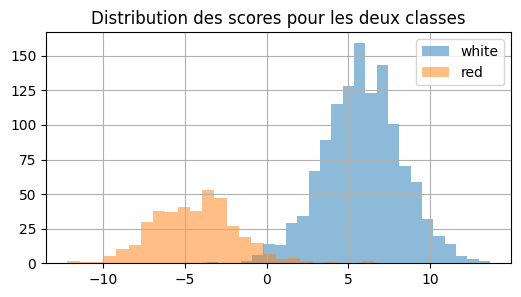

In [6]:
ax = dfsc[dfsc["color"] == "white"]["score"].hist(
    bins=25, figsize=(6, 3), label="white", alpha=0.5
)
dfsc[dfsc["color"] == "red"]["score"].hist(bins=25, ax=ax, label="red", alpha=0.5)
ax.set_title("Distribution des scores pour les deux classes")
ax.legend();

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr0, tpr0, thresholds0 = roc_curve(
    y_test, score, pos_label=clr.classes_[1], drop_intermediate=False
)
fpr0.shape

(1545,)

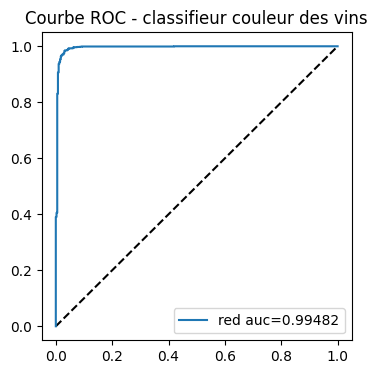

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
# aucf = roc_auc_score(y_test == clr.classes_[0], probas[:, 0]) # première façon
aucf = auc(fpr0, tpr0)  # seconde façon
ax.plot(fpr0, tpr0, label=clr.classes_[0] + " auc=%1.5f" % aucf)
ax.set_title("Courbe ROC - classifieur couleur des vins")
ax.legend();

Voyons ce qu'il se passe en général si nous décidons non pas d'évaluer un modèle qui classifie bien une classe mais les deux classes à la fois. La différence est subtile. Le score est celui de la classe prédite et non plus celui d'une classe.

In [9]:
list_classes = list(clr.classes_)

pred = clr.predict(X_test)
scores = clr.decision_function(X_test)
pred_i = [list_classes.index(c) for c in pred]
probas = clr.predict_proba(X_test)
proba = [probas[i, c] for i, c in enumerate(pred_i)]
score = [scores[i] if c == 0 else -scores[i] for i, c in enumerate(pred_i)]

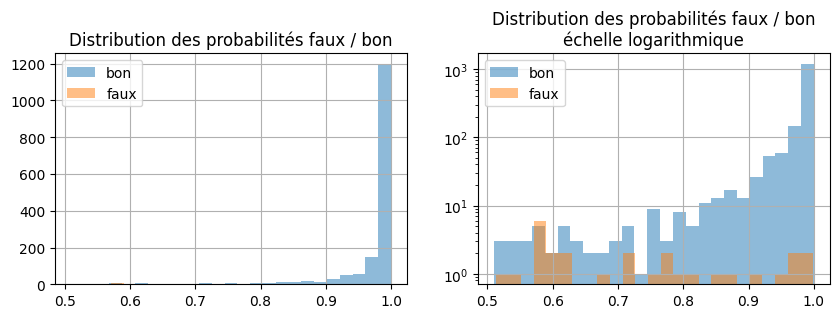

In [10]:
dfpr = pandas.DataFrame(proba, columns=["proba"])
dfpr["color"] = y_test.values

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
dfpr[pred == dfpr["color"]]["proba"].hist(bins=25, label="bon", alpha=0.5, ax=ax[0])
dfpr[pred != dfpr["color"]]["proba"].hist(bins=25, label="faux", alpha=0.5, ax=ax[0])
ax[0].set_title("Distribution des probabilités faux / bon")
ax[0].legend()
dfpr[pred == dfpr["color"]]["proba"].hist(bins=25, label="bon", alpha=0.5, ax=ax[1])
dfpr[pred != dfpr["color"]]["proba"].hist(bins=25, label="faux", alpha=0.5, ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_title("Distribution des probabilités faux / bon\néchelle logarithmique")
ax[1].legend();

Et avec les scores et non plus les probabilités.

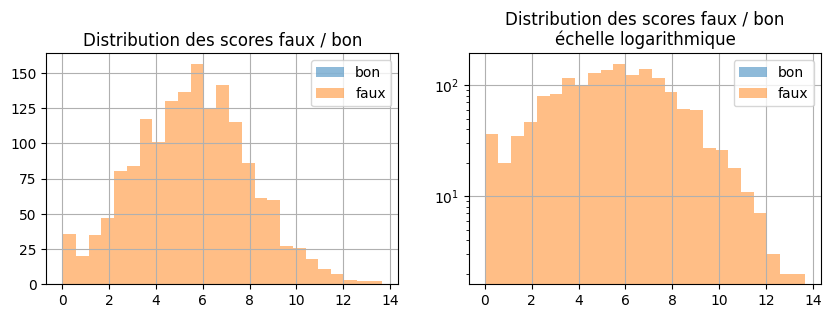

In [11]:
scores = clr.decision_function(X_test)
dfsc = pandas.DataFrame(scores, columns=["score"])
dfsc.loc[pred == "red", "score"] *= -1
dfsc["color"] = y_test.sort_values

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
dfsc[pred == dfsc["color"]]["score"].hist(bins=25, label="bon", alpha=0.5, ax=ax[0])
dfsc[pred != dfsc["color"]]["score"].hist(bins=25, label="faux", alpha=0.5, ax=ax[0])
ax[0].set_title("Distribution des scores faux / bon")
ax[0].legend()
dfsc[pred == dfsc["color"]]["score"].hist(bins=25, label="bon", alpha=0.5, ax=ax[1])
dfsc[pred != dfsc["color"]]["score"].hist(bins=25, label="faux", alpha=0.5, ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_title("Distribution des scores faux / bon\néchelle logarithmique")
ax[1].legend();

In [12]:
fpr, tpr, thresholds = roc_curve(pred == y_test, proba)

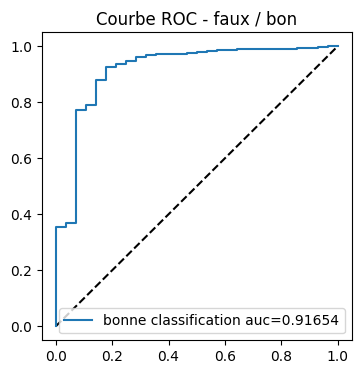

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
aucf = auc(fpr, tpr)  # seconde façon
ax.plot(fpr, tpr, label="bonne classification auc=%1.5f" % aucf)
ax.set_title("Courbe ROC - faux / bon")
ax.legend();

Mais pourquoi les résultats sont-ils moins bons ? Première AUC :

In [14]:
pred = clr.predict(X_test)
scores = clr.decision_function(X_test)
roc_auc_score(y_test == "white", scores)

0.994822102226496

Seconde AUC, on suppose que 0 est la frontière entre les deux classes. Si le score est supérieure à 0, le vin est blanc, sinon il est rouge.

In [15]:
import numpy

pred = numpy.array(["red" if s < 0 else "white" for s in scores])
fpr0, tpr0, thresholds0 = roc_curve(
    y_test == pred, numpy.abs(scores), drop_intermediate=False
)
auc(fpr0, tpr0)

0.9165399409607299

Mais ce n'est peut-être pas le meilleur seuil ? Regardons.

In [16]:
ths = []
aucs = []
n = 100
a, b = -1, 2
for thi in range(0, n + 1):
    th = a + thi * (b - a) * 1.0 / n
    ths.append(th)
    pred = numpy.array(["red" if s - th < 0 else "white" for s in scores])
    fpr, tpr, _ = roc_curve(
        y_test == pred, numpy.abs(scores - th), drop_intermediate=False
    )
    aucs.append(auc(fpr, tpr))

In [17]:
dfa = pandas.DataFrame(dict(th=ths, AUC=aucs))
dfa.describe().T

,count,mean,std,min,25%,50%,75%,max
th,101.0,0.500000,0.879005,-1.000000,-0.250000,0.50000,1.250000,2.000000
AUC,101.0,0.925869,0.007364,0.913118,0.919359,0.92586,0.932542,0.938355


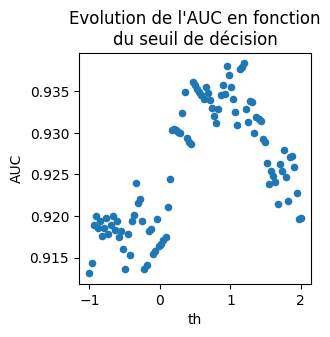

In [18]:
ax = dfa.plot(x="th", y="AUC", figsize=(3, 3), kind="scatter")
ax.set_title("Evolution de l'AUC en fonction\ndu seuil de décision");

Ca aide mais ce n'est toujours pas ça. Changer le seuil aide, il faudrait maintenant changer l'échelle du score, ce qu'on ne fera pas mais rien n'empêche de tracer les fonctions de répartition des scores négatifs et positifs... Voici les distributions.

In [19]:
score = clr.decision_function(X_test)
dfsc = pandas.DataFrame(score, columns=["score"])
dfsc["color"] = y_test.ravel()
dfsc["score_abs"] = dfsc["score"].abs()

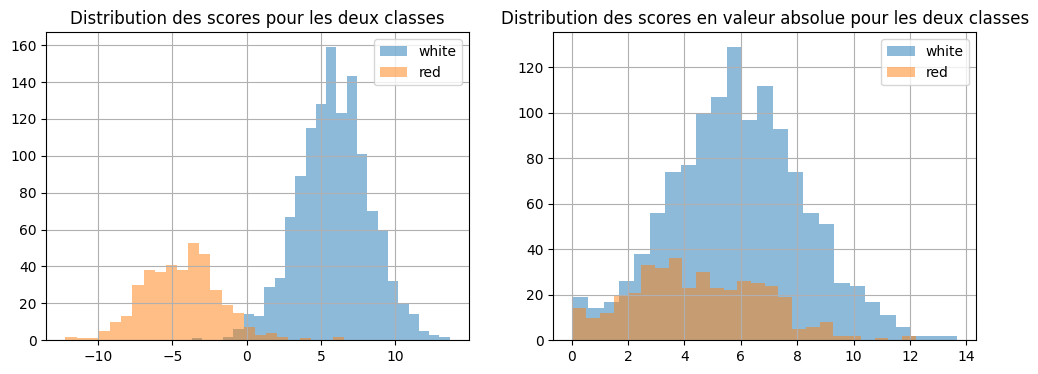

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
dfsc[dfsc["color"] == "white"]["score"].hist(
    bins=25, label="white", alpha=0.5, ax=ax[0]
)
dfsc[dfsc["color"] == "red"]["score"].hist(bins=25, label="red", alpha=0.5, ax=ax[0])
ax[0].set_title("Distribution des scores pour les deux classes")
ax[0].legend()
dfsc[dfsc["color"] == "white"]["score_abs"].hist(
    bins=25, label="white", alpha=0.5, ax=ax[1]
)
dfsc[dfsc["color"] == "red"]["score_abs"].hist(
    bins=25, label="red", alpha=0.5, ax=ax[1]
)
ax[1].set_title("Distribution des scores en valeur absolue pour les deux classes")
ax[1].legend();

In [21]:
red = dfsc[dfsc["color"] == "red"].sort_values("score_abs").reset_index(drop=True)
red["count"] = 1
red["count_sum"] = red["count"].cumsum() * 1.0 / red.shape[0]
red.tail(n=2)

,score,color,score_abs,count,count_sum
394,-11.912383,red,11.912383,1,0.997475
395,-12.204326,red,12.204326,1,1.000000


In [22]:
white = dfsc[dfsc["color"] == "white"].sort_values("score_abs").reset_index(drop=True)
white["count"] = 1
white["count_sum"] = white["count"].cumsum() * 1.0 / white.shape[0]
white.tail(n=2)

,score,color,score_abs,count,count_sum
1227,13.561302,white,13.561302,1,0.999186
1228,13.671458,white,13.671458,1,1.000000


In [23]:
dfscsumabs = pandas.concat([red, white])

On fait pareil pour le score.

In [24]:
red = (
    dfsc[dfsc["color"] == "red"]
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)
red["count"] = 1
red["count_sum"] = red["count"].cumsum() * 1.0 / red.shape[0]
white = dfsc[dfsc["color"] == "white"].sort_values("score").reset_index(drop=True)
white["count"] = 1
white["count_sum"] = white["count"].cumsum() * 1.0 / white.shape[0]
dfscsum = pandas.concat([red, white])

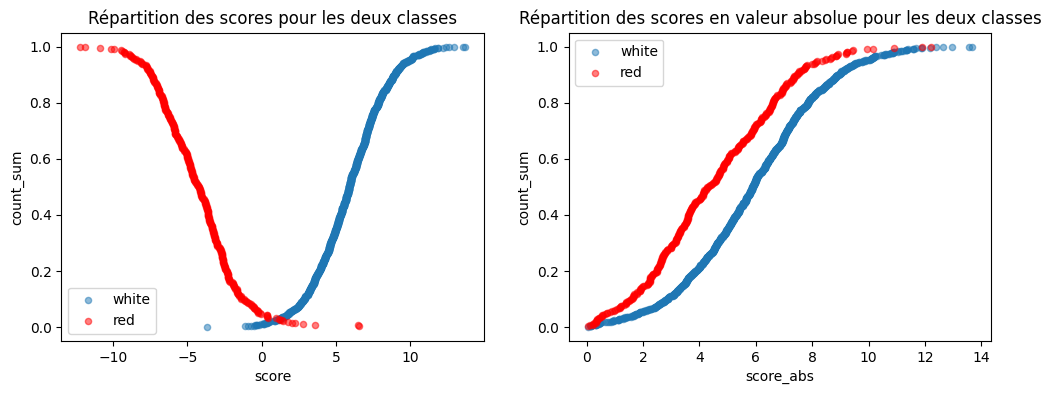

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
dfscsum[dfscsum["color"] == "white"].plot(
    x="score", y="count_sum", kind="scatter", label="white", alpha=0.5, ax=ax[0]
)
dfscsum[dfscsum["color"] == "red"].plot(
    x="score",
    y="count_sum",
    kind="scatter",
    color="red",
    label="red",
    alpha=0.5,
    ax=ax[0],
)
ax[0].set_title("Répartition des scores pour les deux classes")
ax[0].legend()
dfscsumabs[dfscsumabs["color"] == "white"].plot(
    x="score_abs", y="count_sum", kind="scatter", label="white", alpha=0.5, ax=ax[1]
)
dfscsumabs[dfscsumabs["color"] == "red"].plot(
    x="score_abs",
    y="count_sum",
    kind="scatter",
    color="red",
    label="red",
    alpha=0.5,
    ax=ax[1],
)
ax[1].set_title("Répartition des scores en valeur absolue pour les deux classes")
ax[1].legend();

Les deux courbes ne sont pas confondues. Cela veut dire que le score des vins blancs et celui des rouges ne suivent pas les mêmes distributions.